  0.174177 seconds (2.04 M allocations: 93.527 MiB, 14.72% gc time)
 31.049781 seconds (31.85 M allocations: 1.216 GiB, 0.76% gc time)


┌ Info: Saved animation to 
│   fn = C:\Users\Cj\Desktop\Julia\PMprojekt\animacja1.gif
└ @ Plots C:\Users\Cj\.julia\packages\Plots\z5Msu\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\Cj\\Desktop\\Julia\\PMprojekt\\animacja1.gif")
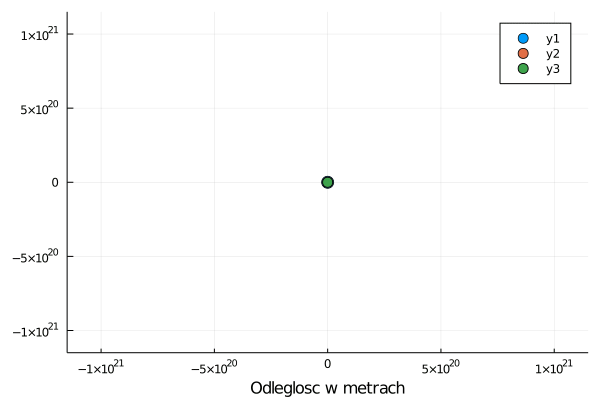

In [83]:
using Plots: length
using Base: Float64
# Głowny program do wyliczania i wyśweitlania położenia ciał 

# Pakiety
using Plots, LinearAlgebra, Statistics, Parameters

# Ważne stałe
Q = 14                    # pozwala używać Float64 zamiast BigFloat
G = 6.6732*10^(-11+2Q)     # stała grawitacji 
def_size = 8.0       # domyślna wielkość wyświetlana na animacji
au = 149597870700 - 10000*Q

# Typ planeta
@with_kw mutable struct My_planet
    name::String
    mass::Float64
    coord::Array{Float64,1}
    v_vec::Array{Float64,1}
    a_vec::Array{Float64,1} = [0, 0]
    size::Float64 = 6.0
    coords_list::Array{Array{Float64,1},1} = []
    v_vecs_list::Array{Float64,1} = []
    a_vecs_list::Array{Float64,1} = []
    every_frame_time::Int64 = 0
end

#--------------------------------------------------------------------------------------------
#       UKŁADY PLANETARNE 
#--------------------------------------------------------------------------------------------

# Układ słoneczny ze Słońcem w centrum heh
Ziemia = My_planet(name = "Ziemia", mass = 5.972*10^(24-Q), coord = [0, 150*10^9], v_vec = [29.78*10^3, 0])
Słońce = My_planet(name = "Słońce", mass = 1.989*10^(30-Q), coord = [0, 0], v_vec = [0, 0])
Merkury = My_planet(name = "Merkury", mass = 3.285*10^(23-Q), coord = [0, -58*10^9], v_vec = [-48*10^3, 0])
Wenus = My_planet(name = "Wenus", mass = 4.867*10^(24-Q), coord = [108.141*10^9, 0], v_vec = [0, -35.02*10^3])
Mars = My_planet(name = "Mars", mass = 6.4171*10^(23-Q), coord = [-227.923*10^9, 0], v_vec = [0, 24.07*10^3])

lista_solar = [Ziemia, Słońce, Merkury, Wenus, Mars]

#UKLAD OGLE

Gwiazda = My_planet(name = "OGLE", mass = 1.989*10^(30-Q)*0.51, coord = [0, 0], v_vec = [0, 0])
Planeta_a = My_planet(name = "Planeta_a", mass = 1.898*10^(27-Q)*0.271, coord = [-1*10^11, 1*10^11], v_vec = [0.22*10^3,-17.87*10^3])
Planeta_b = My_planet(name = "Planeta_b", mass = 1.898*10^(27-Q)*0.71, coord = [-1*10^11, -1*10^11], v_vec = [6*10^3, -18.27*10^3])

lista_OGLE = [Gwiazda, Planeta_a, Planeta_b]

#UKLAD ROSS

ROSE = My_planet(name = "ROSE", mass = 1.898*10^(27-Q)*0.0044, coord = [0, 0], v_vec = [0, 0])
ROSE_1 = My_planet(name = "ROSE_1", mass = 1.898*10^(27-Q)*0.0044, coord = [0, 8.97*10^9], v_vec = [0.22*10^3, -0.35*10^3])
ROSE_2 = My_planet(name = "ROSE_2", mass = 1.898*10^(27-Q)*0.0044, coord = [-8.97*10^9, 0], v_vec = [-0.35*10^3, 0.22*10^3])
ROSE_3 = My_planet(name = "ROSE_3", mass = 1.898*10^(27-Q)*0.0044, coord = [-8.97*10^9, -8.97*10^9], v_vec = [-0.35*10^3, -0.35*10^3])

lista_ROSE = [ROSE, ROSE_1, ROSE_2, ROSE_3]


Purple = My_planet(name = "Purple_sun", mass = 1.898*10^(27-Q)*5, coord = [0, 0], v_vec = [0, 0])
Purple_1 = My_planet(name = "Purple_plan", mass = 1.898*10^(27-Q), coord = [-24*10^3, 11*10^3], v_vec = [0, -2*10^3])
Purple_2 = My_planet(name = "Purple_plan_1", mass = 1.898*10^(27-Q)*0.5, coord = [11*10^3, 0], v_vec = [-0.35*10^3, 0])

lista_purple = [Purple, Purple_1, Purple_2]

#---------------------------------------------------------------------------------------------
#       FUNKCJE DO OBLICZEŃ 
#---------------------------------------------------------------------------------------------

dist_vec(coord1::Array{Float64,1},coord2::Array{Float64,1}) = coord2 .- coord1
"""Wylicza wektor odległości z coord1 do coord2"""

F_gravity(M1::Float64,M2::Float64,r::Array) = (G/norm(r))*(M1/norm(r))*(M2/norm(r)).*r
"""Wylicza wektor siły grawitacji"""

function the_farthest(lista::Array{My_planet,1})
"""Podaj odległość najdalszej planety od środka układu"""
    return maximum(norm(x.coord) for x in lista) 
end

function Scale_size(planeta::My_planet, rel_mass::Float64, def_size = 6)
"""Zwróć przeskalowany rozmiar planety do wyświetlania"""
    return (planeta.mass/rel_mass)^(0.1)*def_size
end

function Scale_planets(lista::Array{My_planet,1})
"""Skaluj planety względem mediany"""
    mass_list = collect(m.mass for m in lista)
    rel_mass = median(mass_list)
    for i in lista
        i.size = Scale_size(i,rel_mass)
    end
end

function MainFunction(lista::Array{My_planet,1},T::Int64)
"""Zmień położenie planety o podaną jednostkę czasu
===================================================
lista - listę obiektów typu My_planet
T - czas w sekundach po jakim przeliczy nową pozycję"""

    for i in eachindex(lista)
        FG=[0.0, 0.0]
        for j in eachindex(lista)
            if j != i
                r = dist_vec(lista[i].coord, lista[j].coord)
                F = F_gravity(lista[i].mass, lista[j].mass, r)
                FG += F
            end
        end
        lista[i].a_vec = FG./lista[i].mass.*(0.1^Q)      # ustawia wektor przyspieszenia planety 
    end
    for i in eachindex(lista)
        lista[i].v_vec += T.*lista[i].a_vec
        lista[i].coord += T.*lista[i].v_vec  
    end
end

function Set_coord_list(planets_list::Array{My_planet,1}, frames::Int64, delta_time::Int64, conversion_number::Int64)
"""Zapisuje położenie, prędkość, przyspiesznie oraz czas przejścia 
do nowego położenia planet w ich atrybutach.
==================================================================
frames - zapisywana ilość klatek( położeń planety)
delta_time - czas w sekundach po jakim przeliczy nową pozycję
conversion_number - ilość przeliczeń na każdą zapisaną klatkę"""
    for i in planets_list
        i.every_frame_time = delta_time*conversion_number
    end

    for i in 1:frames
        for i in planets_list
            push!(i.coords_list, i.coord)
            push!(i.v_vecs_list, norm(i.v_vec))
            push!(i.a_vecs_list, norm(i.a_vec))
        end
        for i in 1:conversion_number
            MainFunction(planets_list,delta_time)
        end   
    end
end

function make_symulation1(planets_list::Array{My_planet,1})
"""Tworzy animację ruchu planet na podstawie zapisanych pozycji w atrybucie coords_list."""

    Scale_planets(planets_list)
    dist_limit = the_farthest(planets_list)*1.2
    symulation = @animate for i in 1:length(planets_list[1].coords_list)
        scatter([planets_list[1].coords_list[i][1]],[planets_list[1].coords_list[i][2]],
        xlim = (-dist_limit, dist_limit),
        ylim = (-dist_limit, dist_limit), 
        markersize = planets_list[1].size)
        xlabel!("Odleglosc w metrach")
        for j in 2:length(planets_list)
            scatter!([planets_list[j].coords_list[i][1]],[planets_list[j].coords_list[i][2]],
            markersize = planets_list[j].size)
        end 
    end
    return symulation
end

function make_symulation2(planets_list::Array{My_planet,1})
"""Tworzy animację bezwględnej prędkości ciała w czasie"""

    symulation = @animate for i in eachindex(planets_list[1].v_vecs_list)
        scatter([i*planets_list[1].every_frame_time], [planets_list[1].v_vecs_list[i]])

        for j in 2:length(planets_list)
            scatter!([i*planets_list[1].every_frame_time], [planets_list[j].v_vecs_list[i]])
        end
    end
    return symulation  
end

function make_symulation3(planets_list::Array{My_planet,1})
"""Tworzy animację bezględnego przyspieszenia ciała w czasie"""

    symulation = @animate for i in eachindex(planets_list[1].a_vecs_list)
        scatter([i*planets_list[1].every_frame_time], [planets_list[1].a_vecs_list[i]])
        
        for j in 2:length(planets_list)
            scatter!([i*planets_list[1].every_frame_time], [planets_list[j].a_vecs_list[i]])
        end
    end
    return symulation   
end


#-------------------------------------------------------------------------------------------
#               SYMULACJA
#-------------------------------------------------------------------------------------------

# PARAMETRY
frames = 1000
delta_time = 3000
conversion_number = 20
fps = 40

#dist_limit = the_farthest(lista_solar)*1.2
#Scale_planets(lista_solar)
#@time Set_coord_list(lista_solar,frames,delta_time,conversion_number)       # ustawia wszystkie listy w atrybutach planet
#@time symulation1 = make_symulation1(lista_solar)      # symulacja orbitowania planet
#gif(symulation1,"animacja1.gif", fps=fps)
#@time symulation2 = make_symulation2(lista_solar)      # symulacja prędkości planet
#gif(symulation2,"animacja2.gif",fps=fps)
#@time symulation3 = make_symulation3(lista_solar)       # symulacja przyspieszenia planet
#gif(symulation3,"animacja3.gif",fps=fps)



#dist_limit = the_farthest(lista_ROSE)*1.2
#Scale_planets(lista_ROSE)
#@time Set_coord_list(lista_ROSE,frames,delta_time,conversion_number)       # ustawia wszystkie listy w atrybutach planet
#@time symulation1 = make_symulation1(lista_ROSE)      # symulacja orbitowania planet
#gif(symulation1,"animacja1.gif", fps=fps)


dist_limit = the_farthest(lista_purple)*1.2
Scale_planets(lista_purple)
@time Set_coord_list(lista_purple,frames,delta_time,conversion_number)       # ustawia wszystkie listy w atrybutach planet
@time symulation1 = make_symulation1(lista_purple)      # symulacja orbitowania planet
gif(symulation1,"animacja1.gif", fps=fps)



#dist_limit = the_farthest(lista_OGLE)*1.2
#Scale_planets(lista_OGLE)
#@time Set_coord_list(lista_OGLE,frames,delta_time,conversion_number)       # ustawia wszystkie listy w atrybutach planet
#@time symulation1 = make_symulation1(lista_OGLE)      # symulacja orbitowania planet
#gif(symulation1,"animacja1.gif", fps=fps)



#   STARE NIEUŻYWANE
#==============================================================================#
#=
symulation1 = @animate for i in 1:frames
    scatter([lista_solar[1].coords_list[i][1]],[lista_solar[1].coords_list[i][2]],
    xlim = (-dist_limit, dist_limit),
    ylim = (-dist_limit, dist_limit), 
    markersize = lista_solar[1].size)

    for j in 2:length(lista_solar)
        scatter!([lista_solar[j].coords_list[i][1]],[lista_solar[j].coords_list[i][2]],
        markersize = lista_solar[j].size) 
    end
end
=#

#@time symulation2 = make_symulation2(lista_solar)
#gif(symulation2,"animacja2.gif", fps=fps)

#=
@time symulation = @animate for i in 1:t
    scatter([lista_solar[1].coord[1]], [lista_solar[1].coord[2]],
    xlim = (-dist_limit, dist_limit),
    ylim = (-dist_limit, dist_limit), 
    markersize = lista_solar[1].size)

    for i in 2:length(lista_solar)
        scatter!([lista_solar[i].coord[1]], [lista_solar[i].coord[2]],
        markersize = lista_solar[i].size)
    end

    for i in 1:n
        MainFunction(lista_solar,T)
    end
end

gif(symulation,"animacja.gif", fps=fps)
=#



